In [2]:
import warnings
import os
import copy
from sklearnex import patch_sklearn
import numpy as npS
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)

warnings.filterwarnings("ignore")

import uuid
from sklearn.experimental import enable_iterative_imputer
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.impute import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.kernel_approximation import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *
from sklearn.covariance import *
from collections import Counter
import sklearn
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.calibration import *
import joblib
from pprint import pprint as pp

pd.options.compute.use_numba = True
pd.options.compute.use_numexpr = True
pd.options.compute.use_bottleneck = True
pd.options.display.max_columns = 90
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import (
    ADASYN,
    SMOTE,
    RandomOverSampler,
    SVMSMOTE,
    SMOTENC,
    SMOTEN,
    BorderlineSMOTE,
    KMeansSMOTE,
)

%matplotlib inline
plt.style.use("fivethirtyeight")

import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory

# patch_sklearn()
KAGGLE_ENV = 1
DATA_INPUT = "/kaggle/input/marketing-strategy-personalised-offer/"
DATA_OUTPUT = "/kaggle/working/"
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd or "u170690" in cwd:
    KAGGLE_ENV = 0
    DATA_INPUT = "kaggle/input/marketing-strategy-personalised-offer/"
    DATA_OUTPUT = "kaggle/working/"
CACHE = Memory(DATA_OUTPUT + "joblib", verbose=0)
patch_sklearn()

data = pd.read_csv(DATA_INPUT + "train_data.csv")
eval_data = pd.read_csv(DATA_INPUT + "test_data.csv")


def gen_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=10
    )
    return X_train, X_test, y_train, y_test


def save_data():
    global data, eval_data
    data.to_parquet(DATA_OUTPUT + "data.parquet")
    eval_data.to_parquet(DATA_OUTPUT + "eval_data.parquet")


def quick_test(X):
    clfs = [
        RandomForestClassifier(class_weight="balanced_subsample", random_state=42),
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        LogisticRegressionCV(max_iter=10000, class_weight="balanced", random_state=42),
    ]
    y = data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.5)
    for clf in clfs:
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"{clf.__class__.__name__} :: {score}")


def check_RF_perf(X, y):
    clf = RandomForestClassifier(
        class_weight="balanced", n_jobs=24, max_features=None, max_depth=8
    )
    with parallel_backend("threading"):
        scores = cross_validate(
            clf,
            X,
            y,
            cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
            n_jobs=24,
            return_train_score=True,
            scoring="f1_macro",
        )
    _ = plt.plot(scores["test_score"], label="TEST")
    _ = plt.plot(scores["train_score"], label="TRAIN")
    _ = plt.legend()


def check_catNB_perf(X, y):
    min_c = X.nunique().astype("int").to_numpy() + 1
    # clf = RandomForestClassifier(class_weight='balanced',
    #                              n_jobs=24,
    # #                              max_features=None,
    #                              )
    class_prior = (y.value_counts() / X.shape[0]).sort_index().to_numpy()
    clf = CategoricalNB(
        fit_prior=True,
        alpha=0.0000003,
        min_categories=min_c,
        #                     class_prior=class_prior
    )
    categories_ = []
    for c in X.columns:
        categories_.append(sorted(list(X[c].unique())))

    work = make_pipeline(OrdinalEncoder(categories=categories_), clf)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.5,
        random_state=42,
        shuffle=True,
        stratify=y,
    )
    with parallel_backend("threading"):
        #     scores = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),n_jobs=24,return_train_score=True,scoring='f1_macro')
        y_pred = work.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_pred, y_test))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# _ = data.isna().sum().plot(kind="bar", rot=90, logy=True, figsize=(10, 8))
# data.nunique()
n_c = [
    "Job/Job Industry",
    "Marital Status",
    "restaurant type",
    "Customer type",
    "Climate",
    "Qualification",
    "drop location",
    "car",
]
# for c in n_c:
#     print(c,"\t:\t",data[c].unique(),'\n')

```text
Job/Job Industry 	:	 ['Unemployed' 'Arts Design Entertainment Sports & Media' 'Sales & Related'
 'Student' 'Business & Financial' 'Computer & Mathematical'
 'Office & Administrative Support' 'Management' 'Healthcare Support'
 'Life Physical Social Science' 'Installation Maintenance & Repair'
 'Legal' 'Community & Social Services' 'Education&Training&Library'
 'Construction & Extraction' 'Healthcare Practitioners & Technical'
 'Transportation & Material Moving' 'Retired' 'Architecture & Engineering'
 'Production Occupations' 'Farming Fishing & Forestry'
 'Protective Service' 'Personal Care & Service'
 'Food Preparation & Serving Related'
 'Building & Grounds Cleaning & Maintenance'] 

Marital Status 	:	 ['Married partner' 'Single' 'Divorced' 'Unmarried partner' 'Widowed'] 

restaurant type 	:	 ['4 star restaurant' 'Take-away restaurant' 'Cold drinks'
 'Restaurant with pub' '2 star restaurant'] 

Customer type 	:	 ['Individual' 'With Family' 'With Kids' 'With Colleagues'] 

Climate 	:	 ['Spring' 'Summer' 'Winter'] 

Qualification 	:	 ['Bachelors degree' 'Some college - no degree'
 'Graduate degree (Masters or Doctorate)' 'Associates degree'
 'High School Graduate' 'Some High School'] 

drop location 	:	 ['Location B' 'Location A' 'Location C'] 

car 	:	 [nan 'Mazda5' 'Car that is too old to install Onstar :D' 'crossover'
 'Scooter and motorcycle' 'do not drive'] 

```

## Data Cleaning If possible Reload Last Saved Data

In [30]:
data = pd.read_csv(DATA_INPUT + "train_data.csv")
eval_data = pd.read_csv(DATA_INPUT + "test_data.csv")

ques = "Do you want to use new data?"
ans = input(prompt=ques)
if ans.lower() == "y":

    def convert_to_hours(row):
        if "hours" in row["offer expiration"]:
            #         row['offer expiration'] = int(row['offer expiration'][:-5])
            row["offer expiration"] = 0
        elif "days" in row["offer expiration"]:
            #         row['offer expiration'] = int(row['offer expiration'][:-4])*24
            row["offer expiration"] = 1
        return row

    data = data.apply(convert_to_hours, axis=1)
    eval_data = eval_data.apply(convert_to_hours, axis=1)

    def pythonise_col_names(df: pd.DataFrame):
        col_names = list(df.columns)
        rename_stubs = {}
        for x in col_names:
            if x == "Offer Accepted":
                r = "target"
                rename_stubs[x] = r
            elif "/" in x:
                r = x.split("/")[1]
                r = r.replace(" ", "_").lower()
                rename_stubs[x] = r
            elif "-" in x:
                r = x.replace("-", "_").lower()
                r = r.replace(" ", "_").lower()
                rename_stubs[x] = r
            elif " " in x:
                r = x.replace(" ", "_").lower()
                rename_stubs[x] = r
            else:
                r = x.lower()
                rename_stubs[x] = r
        return rename_stubs

    data.rename(pythonise_col_names(data), inplace=True, axis=1)
    eval_data.rename(pythonise_col_names(eval_data), inplace=True, axis=1)
    gender_code = {"Male": 0, "Female": 1}

    def binarize_gender(row):
        global gender_code
        row["gender"] = gender_code[row["gender"]]
        return row

    data = data.apply(binarize_gender, axis=1)
    eval_data = eval_data.apply(binarize_gender, axis=1)

    ages_ord = ["below21", "21", "26", "31", "36", "41", "46", "50plus"]
    ordinal_age_codes = {x: idx + 1 for idx, x in enumerate(ages_ord)}
    income_codes = {
        "Less than ₹12500": 1,
        "₹12500 - ₹24999": 2,
        "₹25000 - ₹37499": 3,
        "₹37500 - ₹49999": 4,
        "₹50000 - ₹62499": 5,
        "₹62500 - ₹74999": 6,
        "₹75000 - ₹87499": 7,
        "₹87500 - ₹99999": 8,
        "₹100000 or More": 9,
    }
    ordinal_quali_codes = {
        "Bachelors degree": 5,
        "Some college - no degree": 3,
        "Graduate degree (Masters or Doctorate)": 6,
        "Associates degree": 4,
        "High School Graduate": 2,
        "Some High School": 1,
    }
    data["ordinal__income_range"] = 0
    eval_data["ordinal__income_range"] = 0
    data["ordinal__age"] = 0
    eval_data["ordinal__age"] = 0
    data["ordinal__qualif"] = 0
    eval_data["ordinal__qualif"] = 0

    def codify_special_ordinal_range(row):
        global income_codes, ordinal_age_codes
        row["ordinal__income_range"] = income_codes[row["income_range"]]
        row["ordinal__age"] = ordinal_age_codes[row["age"]]
        row["ordinal__qualif"] = ordinal_quali_codes[row["qualification"]]
        return row

    data = data.apply(codify_special_ordinal_range, axis=1)
    eval_data = eval_data.apply(codify_special_ordinal_range, axis=1)

    ordinal_category_codes = {
        "4~8": 4,
        "less1": 2,
        "never": 1,
        "1~3": 3,
        "gt8": 5,
        np.nan: np.nan,
    }

    # data = data.apply(codify_cold_drink_consumption,axis=1)
    # eval_data = eval_data.apply(codify_cold_drink_consumption,axis=1)
    ord_cols = [
        "restaur_spend_less_than20",
        "no_take_aways",
        "restaur_spend_greater_than20",
        "no_visited_bars",
        "no_visited_cold_drinks",
    ]
    col_ord_names = ["ordinal__" + x for x in ord_cols]
    data[col_ord_names] = 0
    eval_data[col_ord_names] = 0

    def codify_ordinal_columns(row):
        global col_ord_names, ordinal_category_codes, ord_cols
        for ord_col, col_ord_name in zip(ord_cols, col_ord_names):
            try:
                row[col_ord_name] = int(ordinal_category_codes[row[ord_col]])
            except ValueError:
                row[col_ord_name] = ordinal_category_codes[row[ord_col]]
        return row

    data = data.apply(codify_ordinal_columns, axis=1)
    eval_data = eval_data.apply(codify_ordinal_columns, axis=1)

    """
    Car Feature:
    Label NaN as unknown for now
    """
    data.car.fillna("unknown", inplace=True)
    eval_data.car.fillna("unknown", inplace=True)

    nominal_cs = [
        "restaurant_type",
        "marital_status",
        #         "climate",
        "drop_location",
        "job_industry",
        "customer_type",
        "car",
    ]
    nominal_col_names = ["nominal__" + x for x in nominal_cs]
    master_nominals = pd.concat(
        [data[nominal_cs], eval_data[nominal_cs]], ignore_index=True, axis=0
    )
    nominal_encoder = {nc: {} for nc in nominal_cs}
    for c in nominal_cs:
        unique_vals = list(master_nominals[c].unique())
        nominal_codes = {x: idx for idx, x in enumerate(unique_vals)}
        nominal_encoder[c] = nominal_codes
    data[nominal_col_names] = 0
    eval_data[nominal_col_names] = 0
    data["interval__season"] = 0
    eval_data["interval__season"] = 0
    season_code = {"Spring": 1, "Summer": 2, "Winter": 3}

    def assign_numeric_seasons(row):
        row["interval__season"] = season_code[row["climate"]]
        return row

    data = data.apply(assign_numeric_seasons, axis=1)
    eval_data = eval_data.apply(assign_numeric_seasons, axis=1)

    def codify_nominal_columns(row):
        global nominal_col_names, nominal_encoder, nominal_cs
        for nom_col, col_nom_name in zip(nominal_cs, nominal_col_names):
            try:
                row[col_nom_name] = int(nominal_encoder[nom_col][row[nom_col]])
            except ValueError:
                row[col_nom_name] = nominal_encoder[nom_col][row[nom_col]]
        return row

    data = data.apply(codify_nominal_columns, axis=1)
    eval_data = eval_data.apply(codify_nominal_columns, axis=1)

    def drop_const_and_enc_columns(df):
        cols_to_drop = [
            "restaur_spend_less_than20",
            "no_take_aways",
            "restaur_spend_greater_than20",
            "no_visited_bars",
            "no_visited_cold_drinks",
            "restaurant_type",
            "marital_status",
            "climate",
            "qualification",
            "drop_location",
            "job_industry",
            "customer_type",
            "car",
            "income_range",
            "travelled_more_than_5mins_for_offer",
            "age",
        ]
        df = df.drop(cols_to_drop, axis=1)
        return df

    data = drop_const_and_enc_columns(data)
    eval_data = drop_const_and_enc_columns(eval_data)

    data_original_col_order = [
        "offer_expiration",
        "ordinal__income_range",
        "ordinal__no_visited_cold_drinks",
        "travelled_more_than_15mins_for_offer",
        "ordinal__restaur_spend_less_than20",
        "nominal__marital_status",
        "nominal__restaurant_type",
        "ordinal__age",
        "prefer_western_over_chinese",
        "travelled_more_than_25mins_for_offer",
        "ordinal__no_visited_bars",
        "gender",
        "nominal__car",
        "restuarant_same_direction_house",
        "cooks_regularly",
        "nominal__customer_type",
        "ordinal__qualif",
        "is_foodie",
        "ordinal__no_take_aways",
        "nominal__job_industry",
        "restuarant_opposite_direction_house",
        "has_children",
        "visit_restaurant_with_rating_(avg)",
        "temperature",
        "ordinal__restaur_spend_greater_than20",
        "travel_time",
        "interval__season",
        "nominal__drop_location",
        "prefer_home_food",
        "target",
    ]
    eval_data_original_col_order = copy.deepcopy(data_original_col_order)
    eval_data_original_col_order.remove("target")

    data = data.loc[:, data_original_col_order]
    eval_data = eval_data.loc[:, eval_data_original_col_order]
    binary_features = [
        "offer_expiration",
        "travelled_more_than_15mins_for_offer",
        "prefer_western_over_chinese",
        "travelled_more_than_25mins_for_offer",
        "restuarant_same_direction_house",
        "cooks_regularly",
        "is_foodie",
        "restuarant_opposite_direction_house",
        "has_children",
        "prefer_home_food",
        "gender",
    ]
    b_f_rn = {x: "binary__" + x for x in binary_features}
    data.rename(b_f_rn, axis=1, inplace=True)
    eval_data.rename(b_f_rn, axis=1, inplace=True)
    remaining_ordinals = {
        "visit_restaurant_with_rating_(avg)": "ordinal__type_of_rest_rating",
        "temperature": "interval__temperature",
        "travel_time": "interval__travel_time",
    }

    def rename_remaining_ord(df):
        df = df.rename(remaining_ordinals, axis=1)
        return df

    data = rename_remaining_ord(data)
    eval_data = rename_remaining_ord(eval_data)

    target_codes = {"Yes": 1, "No": 0}

    def binarize_target(row):
        global target_codes
        row["target"] = target_codes[row["target"]]
        return row

    data = data.apply(binarize_target, axis=1)
    X = data[eval_data.columns]
    y = data.target
    X_eval = eval_data

    def impute_values(X, y, X_eval):
        imputer = IterativeImputer(
            estimator=RandomForestClassifier(
                class_weight="balanced", random_state=42, n_jobs=-1
            ),
            sample_posterior=False,
            initial_strategy="most_frequent",
            random_state=42,
        )
        #     data.isna().sum()

        with parallel_backend("threading", n_jobs=24):
            data_enc = imputer.fit_transform(X)
            eval_data_enc = imputer.transform(eval_data)
        return data_enc, eval_data_enc

    data_enc, eval_data_enc = impute_values(X, y, X_eval)
    data.loc[:, eval_data.columns] = data_enc
    eval_data.loc[:, :] = eval_data_enc
    data = data.astype(np.uint32)
    eval_data = eval_data.astype(np.uint32)
    save_data()
else:
    data = pd.read_parquet(DATA_OUTPUT + "data.parquet")
    eval_data = pd.read_parquet(DATA_OUTPUT + "eval_data.parquet")


"""
Degree Of Closeness Rather than Nominal Drop Variable.
"""

closeness_ranks = {0: 3, 1: 2, 2: 1}
if "nominal__drop_location" in data.columns:

    def rank_closeness(row):
        """
        It makes sense to rename the nominal drop Location to much more meaningful
        Ordinal Variable based on General Closeness to target Pop.
        """
        row["nominal__drop_location"] = closeness_ranks[row["nominal__drop_location"]]
        return row

    data = data.apply(rank_closeness, axis=1)
    eval_data = eval_data.apply(rank_closeness, axis=1)
    data.rename(
        {"nominal__drop_location": "ordinal__dest_distance"}, axis=1, inplace=True
    )
    eval_data.rename(
        {"nominal__drop_location": "ordinal__dest_distance"}, axis=1, inplace=True
    )
    data.rename(
        {"nominal__drop_location": "ordinal__dest_distance"}, axis=1, inplace=True
    )
    eval_data.rename(
        {"nominal__drop_location": "ordinal__dest_distance"}, axis=1, inplace=True
    )


def html_px(chart):
    f_name = str(uuid.uuid1())[:8] + ".html"
    f_dest = "/home/u164131/msiit/charts/"
    with open(f_dest + f_name, "w+") as fp:
        fp.write(chart.to_html())
    return f_dest + f_name


"""
Variable Groups
"""
nominal = [x for x in eval_data.columns if "nominal_" in x]
ordinal = [x for x in eval_data.columns if "ordinal_" in x]
binary = [x for x in eval_data.columns if "binary_" in x]
interval = [x for x in eval_data.columns if "interval_" in x]

bio = [
    "binary__gender",
    "ordinal__age",
]
personal_info = [
    "nominal__marital_status",
    "binary__has_children",
    "nominal__customer_type",
]
prefs = [
    "binary__prefer_home_food",
    "binary__is_foodie",
    "binary__prefer_western_over_chinese",
    "binary__cooks_regularly",
]
distance = [
    "binary__travelled_more_than_15mins_for_offer",
    "binary__travelled_more_than_25mins_for_offer",
    "binary__restuarant_opposite_direction_house",
    "binary__restuarant_same_direction_house",
]
usage_info = [
    "ordinal__no_visited_cold_drinks",
    "ordinal__restaur_spend_less_than20",
    "ordinal__restaur_spend_greater_than20",
    "ordinal__no_take_aways",
    "ordinal__type_of_rest_rating",
    "ordinal__no_visited_bars",
]

biz_info = [
    "nominal__restaurant_type",
    "binary__offer_expiration",
]
dest = [
    "ordinal__dest_distance",
    "interval__travel_time",
]
weather = ["interval__season", "interval__temperature"]
wealth = [
    "nominal__car",
    "nominal__job_industry",
    "ordinal__income_range",
    "ordinal__qualif",
]
f_groups = {
    "bio": bio,
    "personal_info": personal_info,
    "prefs": prefs,
    "distance": distance,
    "usage_info": usage_info,
    "biz_info": biz_info,
    "dest": dest,
    "weather": weather,
    "wealth": wealth,
}
save_data()
data["pref_profile"] = 0
eval_data["pref_profile"] = 0


def pref_profile(row):
    profile_str = ""
    for c in prefs:
        profile_str += str(row[c])
    profile_code = int(profile_str, 2)
    row["pref_profile"] = profile_code
    return row


data = data.apply(pref_profile, axis=1)
eval_data = eval_data.apply(pref_profile, axis=1)
data.eval(
    "biz_type = (nominal__restaurant_type * 2) + (binary__offer_expiration)",
    inplace=True,
)
eval_data.eval(
    "biz_type = (nominal__restaurant_type * 2) + (binary__offer_expiration)",
    inplace=True,
)
# save_data()
data.rename(
    {"biz_type": "nominal__biz_type", "pref_profile": "nominal__pref_profile"},
    axis=1,
    inplace=True,
)
eval_data.rename(
    {"biz_type": "nominal__biz_type", "pref_profile": "nominal__pref_profile"},
    axis=1,
    inplace=True,
)

"""
Spending Distribution
"""

data["nominal__spend_id"] = 0
eval_data["nominal__spend_id"] = 0
id_code = {
    "22": 6,
    "34": 13,
    "23": 7,
    "33": 12,
    "25": 9,
    "13": 2,
    "12": 1,
    "32": 11,
    "55": 24,
    "11": 0,
    "45": 19,
    "24": 8,
    "35": 14,
    "14": 3,
    "15": 4,
    "31": 10,
    "54": 23,
    "43": 17,
    "44": 18,
    "21": 5,
    "42": 16,
    "53": 22,
    "52": 21,
    "51": 20,
    "41": 15,
}


def derive_spend_id(row):
    cols = [
        "ordinal__restaur_spend_greater_than20",
        "ordinal__restaur_spend_less_than20",
    ]
    i_cde = ""
    for c in cols:
        i_cde += str(row[c])
    row["nominal__spend_id"] = id_code[i_cde]
    return row


data = data.apply(derive_spend_id, axis=1)
eval_data = eval_data.apply(derive_spend_id, axis=1)


data["nominal__direction"] = 0
eval_data["nominal__direction"] = 0
direction_f = [
    "binary__restuarant_opposite_direction_house",
    "binary__restuarant_same_direction_house",
]


def derive_directional_code(row):
    i_cde = ""
    for c in direction_f:
        i_cde += str(row[c])
    row["nominal__direction"] = int(i_cde, 2)
    return row


data = data.apply(derive_directional_code, axis=1)
eval_data = eval_data.apply(derive_directional_code, axis=1)
redundant = [
    "nominal__restaurant_type",
    "binary__offer_expiration",
    "binary__prefer_home_food",
    "binary__is_foodie",
    "binary__prefer_western_over_chinese",
    "binary__cooks_regularly",
    "binary__restuarant_opposite_direction_house",
    "binary__restuarant_same_direction_house",
    "ordinal__restaur_spend_greater_than20",
    "ordinal__restaur_spend_less_than20",
]
extra_effort = [
    "binary__travelled_more_than_15mins_for_offer",
    "binary__travelled_more_than_25mins_for_offer",
]
data["nominal__extra_travel"] = 0
eval_data["nominal__extra_travel"] = 0


def summarize_extra_effort(row):
    i_cde = ""
    for c in extra_effort:
        i_cde += str(row[c])
    row["nominal__extra_travel"] = int(i_cde, 2)
    return row


data = data.apply(summarize_extra_effort, axis=1)
eval_data = eval_data.apply(summarize_extra_effort, axis=1)

pd.options.compute.use_numba = False


def add_cust_type_to_trunc_features(df_, eval_df):
    df = df_.copy()
    cs_type_direc_ = (
        data.groupby(
            ["nominal__customer_type", "nominal__extra_travel", "nominal__direction"]
        )["target"].sum()
        / data.groupby(
            ["nominal__customer_type", "nominal__extra_travel", "nominal__direction"]
        )["target"].count()
    ).sort_values(ascending=False)
    # cs_type_direc.style.bar(axis=0,align='left')
    category_cde = {}
    for i in range(4):
        for j in range(4):
            for k in range(4):
                try:
                    category_cde[str(i) + str(j) + str(k)] = cs_type_direc_.loc[i, j, k]
                except KeyError as e:
                    continue
    cs_type_direc = data.groupby(
        ["nominal__customer_type", "nominal__extra_travel", "nominal__direction"]
    )["target"].count()
    category_count = {}
    for i in range(4):
        for j in range(4):
            for k in range(4):
                try:
                    category_count[str(i) + str(j) + str(k)] = cs_type_direc.loc[
                        i, j, k
                    ]
                except KeyError as e:
                    continue
    freq = dict(Counter(list(category_cde.values())))
    commn_ = [i for i in freq if freq[i] > 1]
    cmmn_label_groups = {
        cmn: [k for k in category_cde if category_cde[k] == cmn] for cmn in commn_
    }

    fg = 500
    spl_cdes = {}
    for k in cmmn_label_groups:
        cmmn_labels = cmmn_label_groups[k]
        for l in cmmn_labels:
            spl_cdes[l] = str(fg)
        fg += 1

    df["nominal__circumstance"] = 0
    eval_df["nominal__circumstance"] = 0

    def add_ctype_to_gen_f(row):
        cols = ["nominal__customer_type", "nominal__extra_travel", "nominal__direction"]
        icde = ""
        for c in cols:
            icde += str(row[c])
        row["nominal__circumstance"] = icde
        if icde in spl_cdes:
            row["nominal__circumstance"] = spl_cdes[icde]
        return row

    df = df.apply(add_ctype_to_gen_f, axis=1)
    eval_df = eval_df.apply(add_ctype_to_gen_f, axis=1)
    mapped_x = list(
        np.union1d(
            df.nominal__circumstance.unique(), eval_df.nominal__circumstance.unique()
        )
    )
    mapped_x_cde = {x: i for i, x in enumerate(mapped_x)}

    def change_str_to_ord_int(row):
        row["nominal__circumstance"] = mapped_x_cde[row["nominal__circumstance"]]
        return row

    df = df.apply(change_str_to_ord_int, axis=1)
    eval_df = eval_df.apply(change_str_to_ord_int, axis=1)
    return df, eval_df


data, eval_data = add_cust_type_to_trunc_features(data, eval_data)

Do you want to use new data? n


In [50]:
redundant = [
    "nominal__restaurant_type",
    "binary__offer_expiration",
    "binary__prefer_home_food",
    "binary__is_foodie",
    "binary__prefer_western_over_chinese",
    "binary__cooks_regularly",
    "binary__restuarant_opposite_direction_house",
    "binary__restuarant_same_direction_house",
    "ordinal__restaur_spend_greater_than20",
    "ordinal__restaur_spend_less_than20",
    "binary__travelled_more_than_15mins_for_offer",
    "binary__travelled_more_than_25mins_for_offer",
    "nominal__customer_type",
]
nr_data = data.drop(redundant, axis=1)
nr_eval_data = eval_data.drop(redundant, axis=1)

In [51]:
nr_data.shape

(12379, 23)

## Data Legends

```text
cutomer_type Legend

0: Individual
1: With Family
2: With Kids
3: With Colleagues
```

```text
marital_status Legend

0: Married Partner
1: Single
2: Divorced
3: UnMarried Partner
4: Widowed
```

In [52]:
X = data[eval_data.columns]
y = data.target
X_eval = eval_data

In [48]:
related_features = (((data.corr().abs() > 0.3).sum(axis=0)) > 1).to_dict()
relf = []

# print("Features that have Linear or Non Linear Relationships\n\n".upper())

for k, v in related_features.items():
    if v:
        relf.append(k)
crr = data.corr()
relations = {f: {} for f in relf}
for f in relf:
    f_crr = crr[f].abs()
    f_rel = crr[f][f_crr[f_crr > 0.3].index].to_dict()
    del f_rel[f]
    relations[f] = f_rel

In [54]:
related_features = (((nr_data.corr().abs() > 0.3).sum(axis=0)) > 1).to_dict()
relf = []

# print("Features that have Linear or Non Linear Relationships\n\n".upper())

for k, v in related_features.items():
    if v:
        relf.append(k)
crr = nr_data.corr()
relations = {f: {} for f in relf}
for f in relf:
    f_crr = crr[f].abs()
    f_rel = crr[f][f_crr[f_crr > 0.3].index].to_dict()
    del f_rel[f]
    relations[f] = f_rel
relations

{'ordinal__age': {'binary__has_children': 0.35223127728466397},
 'binary__has_children': {'ordinal__age': 0.35223127728466397},
 'interval__travel_time': {'ordinal__dest_distance': 0.30161598728786676},
 'ordinal__dest_distance': {'interval__travel_time': 0.30161598728786676}}

In [9]:
len(nominal), len(ordinal), len(binary)
X[nominal].nunique()

nominal__marital_status      5
nominal__restaurant_type     5
nominal__car                 6
nominal__customer_type       4
nominal__job_industry       25
dtype: int64

In [55]:
# Climate     :     ['Spring' 'Summer' 'Winter']
_ = X.corrwith(y, method="kendall").sort_values()
_
# .plot(kind='bar', rot=90)

nominal__extra_travel                          -0.082930
binary__travelled_more_than_25mins_for_offer   -0.082442
binary__travelled_more_than_15mins_for_offer   -0.067833
binary__has_children                           -0.043600
ordinal__age                                   -0.043015
ordinal__qualif                                -0.039262
binary__gender                                 -0.028428
nominal__direction                             -0.020204
binary__restuarant_opposite_direction_house    -0.018697
ordinal__income_range                          -0.012429
nominal__job_industry                          -0.010229
ordinal__dest_distance                         -0.007921
nominal__car                                   -0.002985
binary__prefer_western_over_chinese            -0.001829
binary__cooks_regularly                         0.000035
ordinal__type_of_rest_rating                    0.004607
binary__restuarant_same_direction_house         0.006482
binary__is_foodie              

In [60]:
check_catNB_perf(nr_data[nr_eval_data.columns], y)

              precision    recall  f1-score   support

           0       0.45      0.55      0.49      2172
           1       0.72      0.63      0.67      4018

    accuracy                           0.60      6190
   macro avg       0.58      0.59      0.58      6190
weighted avg       0.62      0.60      0.61      6190



In [62]:
import phik

In [63]:
pd.options.compute.use_numba = False
data_bins = data.nunique().to_dict()
phi = data.global_phik(
    interval_cols=ordinal,
    bins=data_bins,
)
pd.options.compute.use_numba = True

In [64]:
X = data[eval_data.columns]
y = data.target
X_eval = eval_data
pd.options.compute.use_numba = False
data_bins = X.nunique().to_dict()
groups = list(f_groups.values()) + [ordinal, nominal, binary, interval]
phi_data = []
for fg in groups:
    phi = X.global_phik(interval_cols=fg, bins=data_bins, noise_correction=False)
    phi_data.append(phi[0])
pd.options.compute.use_numba = True
group_names = list(f_groups.keys()) + ["ordinal", "nominal", "binary", "interval"]
phi_df = pd.DataFrame()
for i, p in enumerate(phi_data):
    phi_df[group_names[i]] = p.ravel()
    # p_ser = pd.Series(p.ravel(),name=i)

    # print(p)


pd.options.compute.use_numba = False
# data.phik_matrix(interval_cols=interval).style.background_gradient()
phik = data.phik_matrix(interval_cols=interval)

In [65]:
pd.options.compute.use_numba = False
data_bins = nr_data.nunique().to_dict()
phi = nr_data.global_phik(
    interval_cols=interval,
    bins=data_bins,
)
pd.options.compute.use_numba = True

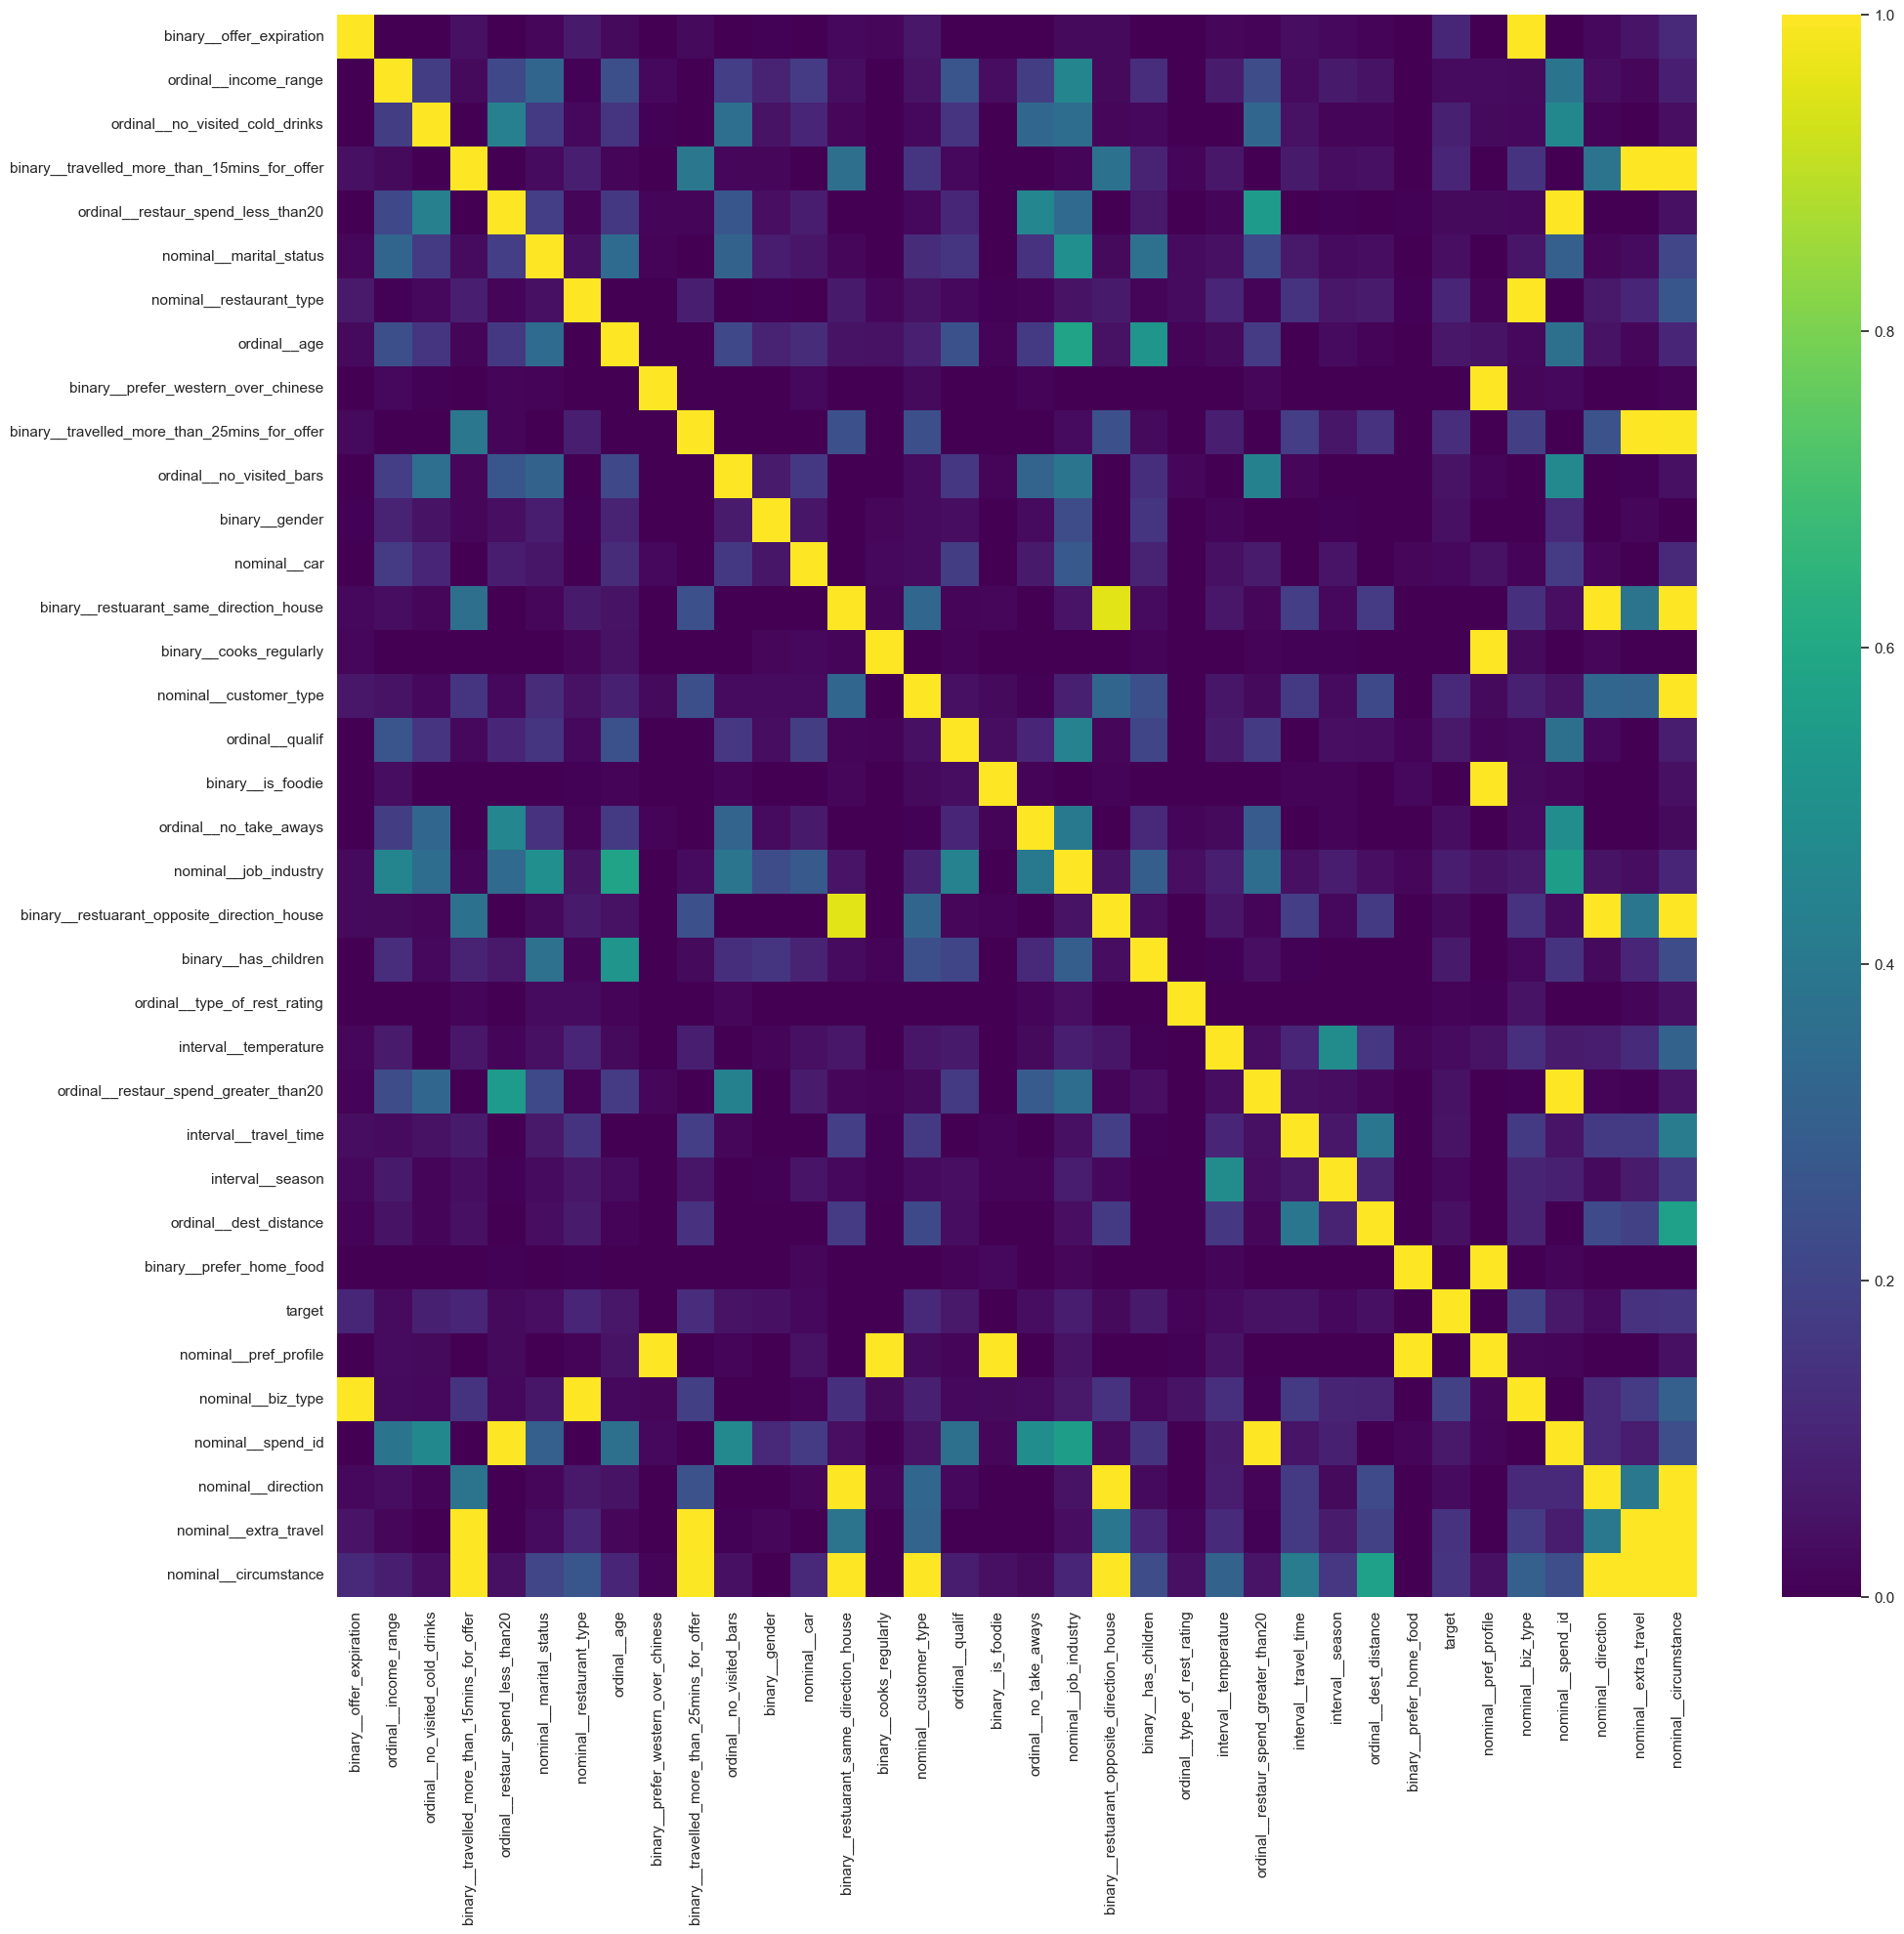

In [66]:
plt.figure(figsize=(20, 20))
_ = sns.heatmap(phik, cmap="viridis")

In [ ]:
master_data = pd.concat([data[eval_data.columns], eval_data], ignore_index=True, axis=0)


def acceptance_ratio(df_):
    df = df_.copy()
    df.rename({1: "yes", 0: "no"}, axis="columns", inplace=True)
    df.eval("t = yes+no", inplace=True)
    df["yes"] = df["yes"] / df["t"]
    df["no"] = df["no"] / df["t"]
    df.eval("acceptance = (yes/no)", inplace=True)
    df = df.loc[:, ["acceptance"]]
    return df


# Male
male = data.groupby(bio)["target"].value_counts().unstack().loc[0, :, :]
male = acceptance_ratio(male)
# Female
female = data.groupby(bio)["target"].value_counts().unstack().loc[1, :, :]
female = acceptance_ratio(female)
gender_acceptance_rate = pd.DataFrame()
gender_acceptance_rate["male"] = male
gender_acceptance_rate["female"] = female
_ = gender_acceptance_rate.plot(kind="bar", title="Gender Age Acceptance Ratio".upper())

In [ ]:
destination_travel_time = (
    master_data.groupby("nominal__drop_location")["interval__travel_time"]
    .value_counts()
    .unstack()
)
destination_travel_time = destination_travel_time.divide(
    destination_travel_time.sum(axis=1), axis=0
)
time_code = {7: "s", 10: "t", 14: "f", 18: "e", 22: "w"}
destination_travel_time.rename(time_code, axis="columns", inplace=True)
destination_travel_time.eval(
    "Ex = ((7*s)+ (10*t) + (14*f) + (18*e) + (22*w))", inplace=True
)
destination_travel_time.eval(
    "Ex2 = ((49*s)+ (100*t) + (196*f) + (324*e) + (484*w))", inplace=True
)
destination_travel_time.eval("Std = (Ex2 - (Ex*Ex))**0.5", inplace=True)
# _ = destination_travel_time['avg_time'].plot(kind='bar',title='avg. time to reach'.upper())
destination_travel_time
_ = plt.bar(
    x=destination_travel_time.index,
    height=destination_travel_time["Ex"],
    label="Average Travel Time",
)
_ = plt.xticks([0, 1, 2])
_ = plt.plot(destination_travel_time["Std"], "-r", label="deviation")
_ = plt.legend()

In [26]:
related_features = (((phik > 0.3).sum(axis=0)) > 1).to_dict()
relf = []

# print("Features that have Linear or Non Linear Relationships\n\n".upper())

for k, v in related_features.items():
    if v:
        relf.append(k)
crr = phik
relations = {f: [] for f in relf}
for f in relf:
    f_crr = crr[f].abs()
    f_rel = crr[f][f_crr[f_crr > 0.3].index].to_dict()
    del f_rel[f]
    relations[f] = {k: {"weight": v} for k, v in f_rel.items()}

In [ ]:
rel_adj = {}
for k in relations:
    rel_adj[k] = []
    for i, j in relations[k].items():
        rel_adj[k].append((i, j))

In [ ]:
[f"{i} : {len(rel_adj[i])}" for i in rel_adj]

In [ ]:
z = data.groupby("nominal__customer_type")[bio].count()
y = data.groupby("nominal__customer_type")[bio].sum()
y["female"] = z["binary__gender"] - y["binary__gender"]
y.eval("binary__gender = binary__gender/female", inplace=True)
y["mf_ratio"] = y["binary__gender"]
y.drop(["binary__gender", "female"], axis=1, inplace=True)
y

In [ ]:
ratio_has_kids_per_marital_status = (
    data.groupby("nominal__marital_status")["binary__has_children"].sum()
    / data.groupby("nominal__marital_status")["binary__has_children"].count()
)
ratio_has_kids_per_marital_status

In [ ]:
for b_f in binary:
    e = data.groupby(b_f)["target"].value_counts().unstack()
    acceptance_ratio = e.iloc[:, 1] / e.iloc[:, 0]
    binary_compare = acceptance_ratio[1] / acceptance_ratio[0]
    print(b_f, " : ", binary_compare)

In [ ]:
bio_pref_ratio = (
    data.groupby(bio)[prefs + ["target"]].sum()
    / data.groupby(bio)[prefs + ["target"]].count()
)
bio_pref_ratio.style.background_gradient()

In [ ]:
pref_profile_acceptance_rate = (
    data.groupby("pref_profile")["target"].sum()
    / data.groupby("pref_profile")["target"].count()
)
pref_profile_acceptance_rate.sort_values(ascending=False)

In [ ]:
X = data[eval_data.columns]
y = data["target"]
clf = HistGradientBoostingClassifier(
    categorical_features=[True] * 30,
    random_state=42,
    learning_rate=0.1,
    max_iter=1000,
    scoring="f1_macro",
    early_stopping=True,
    max_depth=15,
)
# clf = RandomForestClassifier(class_weight='balanced',n_jobs=-1,random_state=42,max_depth=5)
# clf = LogisticRegressionCV(max_iter=100000)
with parallel_backend("loky"):
    scores = cross_validate(
        clf,
        X,
        y,
        scoring="f1_macro",
        n_jobs=-1,
        return_train_score=True,
        cv=RepeatedStratifiedKFold(n_repeats=2),
    )
scores

In [ ]:
X_master = pd.concat([data[eval_data.columns], eval_data], ignore_index=True, axis=0)


def get_logit_ordinal(X):
    probit = {c: {} for c in ordinal}

    for c in ordinal:
        vc = X_master[c].value_counts()
        N = X_master.shape[0]
        vc = vc / N
        probit_value = {val: 0 for val in X_master[c].unique()}
        for val in X_master[c].unique():
            probit_value[val] = np.log(
                (vc[vc.index <= val].sum()) / (vc[vc.index > val].sum() + 1e-09)
            )
        probit[c] = probit_value

    def transform_ordinal_to_logit(row):
        for c in ordinal:
            row[c] = probit[c][row[c]]
        return row

    probit_x = pd.DataFrame(X, columns=ordinal)
    probit_x = probit_x.apply(transform_ordinal_to_logit, axis=1)
    return probit_x

In [ ]:
logit_X = get_logit_ordinal(X)

In [ ]:
X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.2)

In [ ]:
clf = HistGradientBoostingClassifier(categorical_features=[True]*30,random_state=42,learning_rate=0.1,max_iter=10000,early_stopping=True,scoring='f1_macro',validation_fraction=0.1,max_depth=9,min_samples_leaf=50
                                    )
X = data[eval_data.columns]redundant = [
    'nominal__restaurant_type',
    'binary__offer_expiration',
    'binary__prefer_home_food',
    'binary__is_foodie',
    'binary__prefer_western_over_chinese',
    'binary__cooks_regularly'
]
y = data.target
X_train, X_test,y_train, y_test = gen_train_test(X,y,test_size=0.2)
clf = RandomForestClassifier(class_weight='balanced_subsample',n_jobs=-1,random_state=2)
clf.fit(X_train,y_train)
f1_score(y_test,clf.predict(X_test),average='macro')

In [ ]:
RF_feat_imp = pd.DataFrame(
    clf.feature_importances_, index=clf.feature_names_in_, columns=["Values"]
)
RF_feat_imp.sort_values(by="Values", ascending=False).style.background_gradient()

In [ ]:
consumer_groups = [None] * 16
for i in range(16):
    consumer_groups[i] = data[data.pref_profile == i].index

other_fs = np.setdiff1d(data.columns, prefs + ["target", "pref_profile"])
data_chunks = []
for idx in consumer_groups:
    data_chunks.append(data.loc[idx, other_fs])
clf = RandomForestClassifier(n_jobs=-1, random_state=2, warm_start=True)
clf = HistGradientBoostingClassifier(
    categorical_features=[True] * 25,
    random_state=42,
    learning_rate=0.1,
    max_iter=10000,
    early_stopping=True,
    scoring="f1_macro",
    validation_fraction=0.1,
    warm_start=True,
)
clfs = [clf] * 16

In [ ]:
for clf, X in zip(clfs, data_chunks):
    #     print(len(X))
    X_train, X_test, y_train, y_test = gen_train_test(
        X, data.target.loc[X.index], test_size=0.15
    )
    clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)

    sc = f1_score(y_test, clf.predict(X_test), average="macro")
    print(sc)

In [ ]:
pd.options.compute.use_numba = False
data.groupby(["interval__season", "interval__temperature"])[
    "target"
].sum() / data.groupby(["interval__season", "interval__temperature"])["target"].count()

In [ ]:
data.groupby(["interval__season", "interval__temperature"])["target"].count()

In [ ]:
eval_data.groupby(["interval__season", "interval__temperature"])[
    "ordinal__income_range"
].count()

In [13]:
pd.options.compute.use_numba = False
X = data[eval_data.columns].copy()
y = data["target"].copy()
X_eval = eval_data.copy()
redundant = [
    "nominal__restaurant_type",
    "binary__offer_expiration",
    "binary__prefer_home_food",
    "binary__is_foodie",
    "binary__prefer_western_over_chinese",
    "binary__cooks_regularly",
]
X.drop(redundant, axis=1, inplace=True)
X_eval.drop(redundant, axis=1, inplace=True)
X_master = pd.concat([X[X_eval.columns], X_eval], ignore_index=True, axis=0)
nominal = [x for x in X_eval.columns if "nominal" in x]
ordinal = [x for x in X_eval.columns if "ordinal" in x]
binary = [x for x in X_eval.columns if "binary" in x]
nominal_categories = []
for c in nominal + ["interval__season"]:
    nominal_categories.append(sorted(X_master[c].unique()))

transform_data = make_column_transformer(
    (
        OneHotEncoder(categories=nominal_categories, sparse=False),
        nominal + ["interval__season"],
    ),
    #     (BaseNEncoder(cols=nominal+['interval__season']),nominal+['interval__season']),
    (
        TargetEncoder(
            cols=ordinal + ["interval__temperature", "interval__travel_time"]
        ),
        ordinal + ["interval__temperature", "interval__travel_time"],
    ),
    ("passthrough", binary),
    sparse_threshold=False,
    remainder="drop",
)

transform_data.fit(X, y)
X_enc = pd.DataFrame(
    transform_data.transform(X),
    columns=list(
        transform_data.named_transformers_["onehotencoder"].get_feature_names_out()
    )
    + ordinal
    + ["interval__temperature", "interval__travel_time"]
    + binary,
)
# X_enc = pd.DataFrame(transform_data.transform(X),columns= transform_data.named_transformers_['basenencoder'].get_feature_names() + ordinal+['interval__temperature','interval__travel_time'] + binary)
transform_data

ColumnTransformer(sparse_threshold=False,
                  transformers=[('onehotencoder',
                                 OneHotEncoder(categories=[[0, 1, 2, 3, 4],
                                                           [0, 1, 2, 3, 4, 5],
                                                           [0, 1, 2, 3],
                                                           [0, 1, 2, 3, 4, 5, 6,
                                                            7, 8, 9, 10, 11, 12,
                                                            13, 14, 15, 16, 17,
                                                            18, 19, 20, 21, 22,
                                                            23, 24],
                                                           [0, 1, 2, 3, 4, 5, 6,
                                                            7, 8, 9, 10, 11, 12,
                                                            13, 14, 15],
                                                           [0, 1, 2, 3, 4, 5, 6,
                                                            7, 8, 9],
                                                           [0, 1, 2, 3, 4, 5, 6,
                                                            7, 8, 9, 10, 11, 12,
                                                            13, 14, 15, 16, 17,
                                                            18, 19, 20, 21, 22,
                                                            23, 24],
                                                           [0, 1, 2, 3],
                                                           [0, 1, 2, 3],...
                                  'ordinal__restaur_spend_greater_than20',
                                  'ordinal__dest_distance',
                                  'interval__temperature',
                                  'interval__travel_time']),
                                ('passthrough', 'passthrough',
                                 ['binary__travelled_more_than_15mins_for_offer',
                                  'binary__travelled_more_than_25mins_for_offer',
                                  'binary__gender',
                                  'binary__restuarant_same_direction_house',
                                  'binary__restuarant_opposite_direction_house',
                                  'binary__has_children'])])

In [135]:
sel = RFECV(
    RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=2),
    scoring="f1_macro",
    n_jobs=-1,
    cv=StratifiedKFold(),
)
with parallel_backend("loky"):
    sel.fit(X_enc, y)

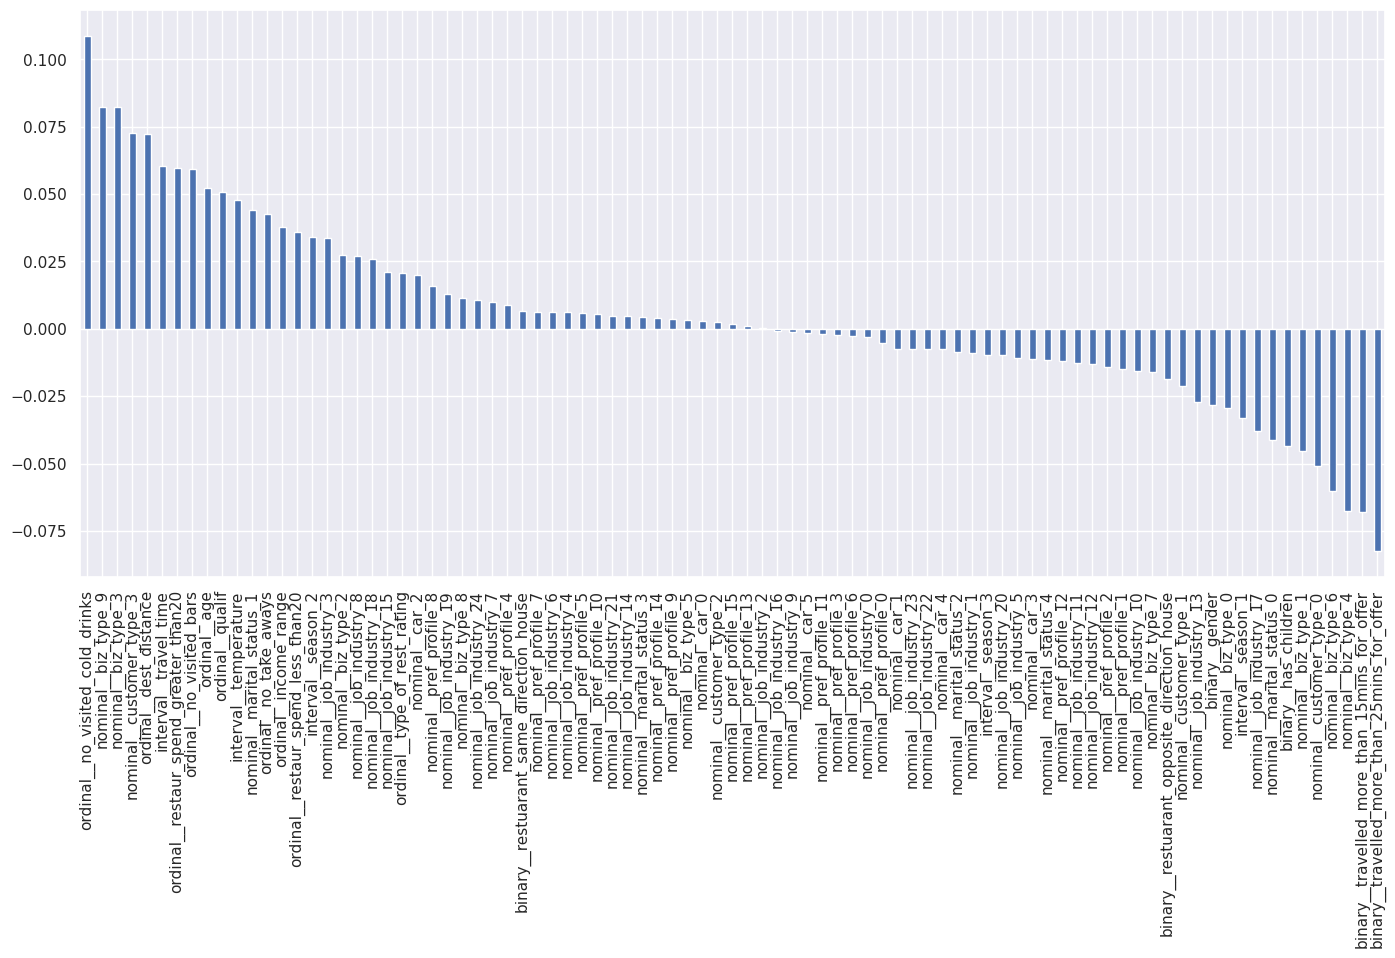

In [8]:
_ = (
    X_enc.corrwith(y)
    .sort_values(ascending=False)
    .plot(kind="bar", rot=90, figsize=(15, 7))
)

In [11]:
X = data[eval_data.columns].copy()
y = data["target"].copy()
X_eval = eval_data.copy()

In [ ]:
data.groupby(biz_info)["target"].sum() / data.groupby(biz_info)["target"].count()

In [ ]:
eval_data.groupby(biz_info)["ordinal__income_range"].count() / data.groupby(biz_info)[
    "target"
].count()

In [ ]:
clf = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation="relu",
    solver="adam",
    alpha=0.0001,
    batch_size="auto",
    learning_rate="invscaling",
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=2000,
    shuffle=True,
    random_state=None,
    tol=0.0001,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=True,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=10,
    #     max_fun=15000
)

In [14]:
original_data = pd.read_csv(DATA_INPUT + "train_data.csv")
list(original_data.columns)
# .style.background_gradient()
c = "restaurant type"
original_data[c].value_counts()

Cold drinks             3471
2 star restaurant       2642
Take-away restaurant    2341
4 star restaurant       2199
Restaurant with pub     1726
Name: restaurant type, dtype: int64

In [17]:
data[ordinal].mode()

,ordinal__income_range,ordinal__no_visited_cold_drinks,ordinal__restaur_spend_less_than20,ordinal__age,ordinal__no_visited_bars,ordinal__qualif,ordinal__no_take_aways,ordinal__type_of_rest_rating,ordinal__restaur_spend_greater_than20,ordinal__dest_distance
0,3,2,3,2,1,3,3,1,2,2


```text
"Cold drinks"             :2
"2 star restaurant "      :4
"Take-away restaurant"    :1
"4 star restaurant   "    :0
"Restaurant with pub  "   :3
```

In [14]:
cold_drink_rest_data = data[data["nominal__restaurant_type"] == 2]
bar_data = data[data["nominal__restaurant_type"] == 3]
take_away_data = data[data["nominal__restaurant_type"] == 1]
pd.options.compute.use_numba = True
take_away_users_acceptance_rate = (
    take_away_data.groupby("ordinal__no_take_aways")["target"].sum()
    / take_away_data.groupby("ordinal__no_take_aways")["target"].count()
)
take_away_users_acceptance_rate

ordinal__no_take_aways
1    0.576923
2    0.610119
3    0.654930
4    0.674279
5    0.630508
Name: target, dtype: float64

In [17]:
cold_drink_users_acceptance_rate = (
    cold_drink_rest_data.groupby("ordinal__no_visited_cold_drinks")["target"].sum()
    / cold_drink_rest_data.groupby("ordinal__no_visited_cold_drinks")["target"].count()
)
cold_drink_users_acceptance_rate

ordinal__no_visited_cold_drinks
1    0.323149
2    0.535398
3    0.610687
4    0.620758
5    0.647651
Name: target, dtype: float64

In [18]:
bar_users_acceptance_rate = (
    bar_data.groupby("ordinal__no_visited_bars")["target"].sum()
    / bar_data.groupby("ordinal__no_visited_bars")["target"].count()
)
bar_users_acceptance_rate

ordinal__no_visited_bars
1    0.464912
2    0.500000
3    0.526946
4    0.539877
5    0.641509
Name: target, dtype: float64

In [19]:
data.groupby(
    [
        "ordinal__no_visited_bars",
        "ordinal__no_visited_cold_drinks",
        "ordinal__no_take_aways",
    ]
)["target"].count()
data.groupby(["ordinal__no_visited_bars"])[
    "ordinal__no_take_aways"
].value_counts().unstack().style.background_gradient()

ordinal__no_take_aways,1,2,3,4,5
ordinal__no_visited_bars,,,,,
1,124,956,2047,1456,551
2,6,437,1354,1118,504
3,6,285,830,1102,208
4,2,60,369,438,178
5,2,25,124,59,138


```
More Qualification leads to lesser Acceptance Chances
```

In [48]:
data.groupby("ordinal__restaur_spend_less_than20")["target"].sum() / data.groupby(
    "ordinal__restaur_spend_less_than20"
)["target"].count()

ordinal__restaur_spend_less_than20
1    0.552885
2    0.538649
3    0.558439
4    0.578586
5    0.600000
Name: target, dtype: float64

In [49]:
data.groupby("ordinal__restaur_spend_greater_than20")["target"].sum() / data.groupby(
    "ordinal__restaur_spend_greater_than20"
)["target"].count()

ordinal__restaur_spend_greater_than20
1    0.538797
2    0.549068
3    0.589640
4    0.633427
5    0.651685
Name: target, dtype: float64

In [20]:
data.groupby("ordinal__restaur_spend_less_than20")[
    "ordinal__restaur_spend_greater_than20"
].value_counts().unstack().style.bar(axis=1)

ordinal__restaur_spend_greater_than20,1,2,3,4,5
ordinal__restaur_spend_less_than20,,,,,
1,138,19,49,1,1
2,601,1136,244,66,10
3,808,2975,1397,154,22
4,427,1585,1127,322,32
5,88,399,407,169,202


In [18]:
pd.options.compute.use_numba = False
j_pivot = data.groupby("nominal__job_industry")[ordinal].agg(pd.Series.mode)
j_pivot.iloc[7, 4] = 3
j_pivot.iloc[24, 3] = 5
j_pivot.iloc[19, 1] = 5
j_pivot.iloc[4, 7] = 3
j_pivot.iloc[18, 7] = 4
j_pivot.iloc[20, 7] = 4

In [227]:
X = nr_data[nr_eval_data.columns]
y = nr_data.target
X_eval = nr_eval_data
enc = TargetEncoder(cols=nr_eval_data.columns, smoothing=0.00001)
embed = RandomTreesEmbedding(warm_start=True)
enc = OneHotEncoder(sparse=False)
X_enc = enc.fit_transform(X)

X_train, X_test, y_train, y_test = gen_train_test(X_enc, y, test_size=0.3)
# X_enc=embed.fit_transform(X_train,y_train)
# X_t_enc = embed.transform(X_test)
# X_enc = enc.fit_transform(X,y)
# clf = make_pipeline(embed,LogisticRegression(fit_intercept=False,warm_start=True,C=0.04641,solver='saga',l1_ratio=0.2,random_state=32,n_jobs=-1,max_iter=10000,))
clf = LogisticRegression(
    fit_intercept=False,
    warm_start=True,
    C=0.04641,
    #                          solver='saga',l1_ratio=0.2,random_state=32,n_jobs=-1,max_iter=10000,
)
clf = MLPClassifier(warm_start=True)
clf = HistGradientBoostingClassifier(
    categorical_features=[True] * 22,
    scoring="f1_macro",
    max_iter=5000,
    max_leaf_nodes=None,
    early_stopping=True,
    tol=1e-04,
    warm_start=True,
)
clf = RandomForestClassifier(
    n_jobs=-1,
    n_estimators=500,
    class_weight="balanced",
    warm_start=True,
    random_state=42,
)
# clf = AdaBoostClassifier(base_estimator=clf,algorithm='SAMME')
clf = MultinomialNB(alpha=0)
# clf=KNeighborsClassifier(metric='hamming',weights="distance",n_neighbors=3)

In [ ]:
with parallel_backend("loky", n_jobs=-1):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test, y_pred))

In [125]:
clf.fit(X_test, y_test)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.52      0.54      2693
           1       0.65      0.70      0.68      3497

    accuracy                           0.62      6190
   macro avg       0.61      0.61      0.61      6190
weighted avg       0.62      0.62      0.62      6190



In [238]:
pca = SparsePCA(n_components=2)
pca.fit(X_enc)

SparsePCA(n_components=2)

In [240]:
pca_x = pca.transform(X_enc)

In [249]:
clf = GaussianProcessClassifier(
    kernel=kernels.PairwiseKernel(metric="chi2"), warm_start=True
)

In [248]:
kernels.PairwiseKernel(metric="jaccard")

'jaccard'

In [29]:
pd.options.compute.use_numba = False


def add_cust_type_to_trunc_features(df_, eval_df):
    df = df_.copy()
    cs_type_direc_ = (
        data.groupby(
            ["nominal__customer_type", "nominal__extra_travel", "nominal__direction"]
        )["target"].sum()
        / data.groupby(
            ["nominal__customer_type", "nominal__extra_travel", "nominal__direction"]
        )["target"].count()
    ).sort_values(ascending=False)
    # cs_type_direc.style.bar(axis=0,align='left')
    category_cde = {}
    for i in range(4):
        for j in range(4):
            for k in range(4):
                try:
                    category_cde[str(i) + str(j) + str(k)] = cs_type_direc_.loc[i, j, k]
                except KeyError as e:
                    continue
    cs_type_direc = data.groupby(
        ["nominal__customer_type", "nominal__extra_travel", "nominal__direction"]
    )["target"].count()
    category_count = {}
    for i in range(4):
        for j in range(4):
            for k in range(4):
                try:
                    category_count[str(i) + str(j) + str(k)] = cs_type_direc.loc[
                        i, j, k
                    ]
                except KeyError as e:
                    continue
    freq = dict(Counter(list(category_cde.values())))
    commn_ = [i for i in freq if freq[i] > 1]
    cmmn_label_groups = {
        cmn: [k for k in category_cde if category_cde[k] == cmn] for cmn in commn_
    }

    fg = 500
    spl_cdes = {}
    for k in cmmn_label_groups:
        cmmn_labels = cmmn_label_groups[k]
        for l in cmmn_labels:
            spl_cdes[l] = str(fg)
        fg += 1

    df["nominal__circumstance"] = 0
    eval_df["nominal__circumstance"] = 0

    def add_ctype_to_gen_f(row):
        cols = ["nominal__customer_type", "nominal__extra_travel", "nominal__direction"]
        icde = ""
        for c in cols:
            icde += str(row[c])
        row["nominal__circumstance"] = icde
        if icde in spl_cdes:
            row["nominal__circumstance"] = spl_cdes[icde]
        return row

    df = df.apply(add_ctype_to_gen_f, axis=1)
    eval_df = eval_df.apply(add_ctype_to_gen_f, axis=1)
    mapped_x = list(
        np.union1d(
            df.nominal__circumstance.unique(), eval_df.nominal__circumstance.unique()
        )
    )
    mapped_x_cde = {x: i for i, x in enumerate(mapped_x)}

    def change_str_to_ord_int(row):
        row["nominal__circumstance"] = mapped_x_cde[row["nominal__circumstance"]]
        return row

    df = df.apply(change_str_to_ord_int, axis=1)
    eval_df = eval_df.apply(change_str_to_ord_int, axis=1)
    return df, eval_df


data, eval_data = add_cust_type_to_trunc_features(data, eval_data)
# data = add_cust_type_to_trunc_features(data)

In [22]:
mapped_x = df.nominal__circumstance.unique()
mapped_x_cde = {x: i for i, x in enumerate(mapped_x)}

In [24]:

    cmmn_label_groups
